In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../Kaggle_dataset/ACWV4.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,56.889999,57.200001,56.230000,56.369999,47.750607,30700
1,1/3/2013,56.560001,56.639999,56.470001,56.500000,47.860737,30000
2,1/4/2013,56.490002,56.740002,56.490002,56.689999,48.021675,45700
3,1/7/2013,56.619999,56.619999,56.250000,56.349998,47.733665,49700
4,1/8/2013,56.380001,56.439999,56.250000,56.439999,47.809914,19200


In [3]:
from collections import deque
import random

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 1150.150127.3, cost: 0.015865, total money: 8768.110127
epoch: 20, total rewards: 232.819946.3, cost: 0.050705, total money: 10232.819946
epoch: 30, total rewards: 372.040043.3, cost: 0.002363, total money: 10372.040043
epoch: 40, total rewards: 63.409916.3, cost: 0.016931, total money: 9299.379917
epoch: 50, total rewards: 136.810062.3, cost: 0.004755, total money: 10136.810062
epoch: 60, total rewards: 116.549969.3, cost: 0.002678, total money: 10020.809971
epoch: 70, total rewards: 117.849945.3, cost: 0.002743, total money: 10022.109947
epoch: 80, total rewards: -10.869968.3, cost: 0.002324, total money: 9989.130032
epoch: 90, total rewards: 121.259922.3, cost: 0.000256, total money: 10025.459919
epoch: 100, total rewards: 31.900036.3, cost: 0.003915, total money: 9936.100033
epoch: 

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 3: buy 1 unit at price 56.349998, total balance 9943.650002
day 4, sell 1 unit at price 56.439999, investment 0.159716 %, total balance 10000.090000,
day 7: buy 1 unit at price 56.930000, total balance 9943.160000
day 9, sell 1 unit at price 57.110001, investment 0.316178 %, total balance 10000.270000,
day 13: buy 1 unit at price 57.400002, total balance 9942.869999
day 14, sell 1 unit at price 57.520000, investment 0.209057 %, total balance 10000.389999,
day 18: buy 1 unit at price 58.029999, total balance 9942.360001
day 20, sell 1 unit at price 58.009998, investment -0.034466 %, total balance 10000.369999,
day 24: buy 1 unit at price 58.180000, total balance 9942.189999
day 25, sell 1 unit at price 58.240002, investment 0.103131 %, total balance 10000.430000,
day 36: buy 1 unit at price 58.450001, total balance 9941.980000
day 37: buy 1 unit at price 58.830002, total balance 9883.149998
day 38, sell 1 unit at price 59.389999, investment 1.608210 %, total balance 9942.539997,
day

day 579: buy 1 unit at price 73.629997, total balance 9941.680000
day 580: buy 1 unit at price 74.029999, total balance 9867.650002
day 581: buy 1 unit at price 74.029999, total balance 9793.620003
day 582, sell 1 unit at price 73.830002, investment 0.271635 %, total balance 9867.450005,
day 583, sell 1 unit at price 74.110001, investment 0.108067 %, total balance 9941.560005,
day 584: buy 1 unit at price 73.730003, total balance 9867.830002
day 585: buy 1 unit at price 72.849998, total balance 9794.980003
day 588, sell 1 unit at price 72.839996, investment -1.607460 %, total balance 9867.820000,
day 589, sell 1 unit at price 72.589996, investment -1.546191 %, total balance 9940.409996,
day 590, sell 1 unit at price 72.699997, investment -0.205905 %, total balance 10013.109993,
day 596: buy 1 unit at price 73.940002, total balance 9939.169991
day 597, sell 1 unit at price 73.760002, investment -0.243441 %, total balance 10012.929993,
day 602: buy 1 unit at price 72.660004, total balanc

day 928: buy 1 unit at price 76.809998, total balance 9929.069946
day 929, sell 1 unit at price 74.970001, investment -2.395517 %, total balance 10004.039948,
day 934: buy 1 unit at price 74.970001, total balance 9929.069946
day 935: buy 1 unit at price 75.279999, total balance 9853.789948
day 936: buy 1 unit at price 75.410004, total balance 9778.379944
day 938: buy 1 unit at price 77.000000, total balance 9701.379944
day 939, sell 1 unit at price 76.449997, investment 1.974117 %, total balance 9777.829941,
day 940, sell 1 unit at price 76.209999, investment 1.235388 %, total balance 9854.039940,
day 942, sell 1 unit at price 76.750000, investment 1.776948 %, total balance 9930.789940,
day 943, sell 1 unit at price 75.949997, investment -1.363640 %, total balance 10006.739937,
day 957: buy 1 unit at price 74.510002, total balance 9932.229935
day 958: buy 1 unit at price 74.199997, total balance 9858.029938
day 959, sell 1 unit at price 74.029999, investment -0.644213 %, total balance 

day 1586, sell 1 unit at price 89.339996, investment 0.698822 %, total balance 10004.999916,
day 1599: buy 1 unit at price 89.430000, total balance 9915.569916
day 1600, sell 1 unit at price 88.389999, investment -1.162922 %, total balance 10003.959915,
day 1612: buy 1 unit at price 89.379997, total balance 9914.579918
day 1613, sell 1 unit at price 89.320000, investment -0.067126 %, total balance 10003.899918,
day 1658: buy 1 unit at price 90.269997, total balance 9913.629921
day 1659, sell 1 unit at price 91.330002, investment 1.174261 %, total balance 10004.959923,
day 1668: buy 1 unit at price 93.080002, total balance 9911.879921
day 1669, sell 1 unit at price 92.769997, investment -0.333052 %, total balance 10004.649918,
day 1673: buy 1 unit at price 92.809998, total balance 9911.839920
day 1674, sell 1 unit at price 92.879997, investment 0.075423 %, total balance 10004.719917,
day 1678: buy 1 unit at price 93.639999, total balance 9911.079918
day 1680, sell 1 unit at price 94.360

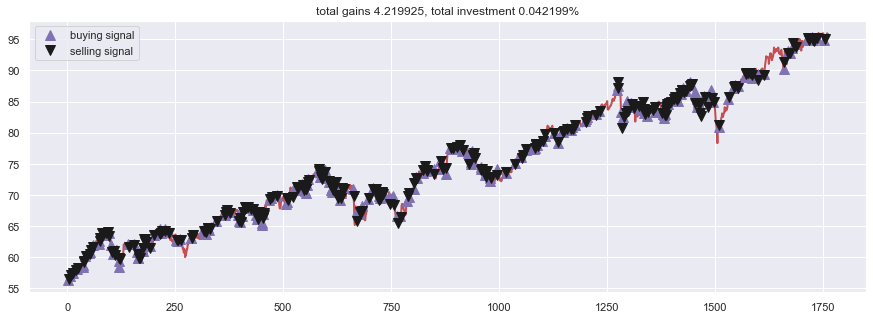

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()